#  數據預處理
* 遺漏值
* 類別變數轉換
* 分割數據:訓練集&測試集
* 特徵縮放  
* 特徵選取  
* 特徵提取(feature extraction)

將透過透過pandas or Scikit-Learn來進行學習與示範

## 遺漏值

In [1]:
import pandas as pd
from io import StringIO
import sys
#\下一行
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,NaN,NaN


確認每欄NA的數量

In [2]:
df.isnull().sum()

A    0
B    0
C    2
D    1
dtype: int64

橫向刪除NA

In [3]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


縱向刪除NA

In [4]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


保留至少還有三個以上值得行

In [5]:
df.dropna(thresh=3)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0


只踢掉D欄有NA的資料

In [6]:
df.dropna(subset=['D'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0


填補NA 

In [7]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., nan, nan]])

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, 
                    strategy='mean'
                   ) 
#strategy 填補的方法 #median #most_frequent眾數
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  3.,  8.],
       [10., 11.,  3.,  6.]])

## 類別變數轉換

In [9]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


### 用字典轉換特徵

In [10]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


反向轉換

In [11]:
inv_size_mapping = {v:k for k, v in size_mapping.items()}
inv_size_mapping

{3: 'XL', 2: 'L', 1: 'M'}

In [12]:
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

In [13]:
 for k, v in size_mapping.items():
    print(k,v)

XL 3
L 2
M 1


### sklearn.preprocessing.LabelEncoder

In [14]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
df['classlabel'] = class_le.fit_transform(df['classlabel'].values) 
#fit_transform()先後呼叫fit & transform
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


反向轉換

In [15]:
class_le.inverse_transform(df['classlabel'])

array(['class2', 'class1', 'class2'], dtype=object)

### One hot encoding

In [16]:
x = df[['color', 'size', 'price']].values
#color_le = LabelEncoder()
#x[:, 0] = color_le.fit_transform(x[:, 0])
x

array([['green', 1, 10.1],
       ['red', 2, 13.5],
       ['blue', 3, 15.3]], dtype=object)

#### scikit-learn

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

ohe = ColumnTransformer([("color", OneHotEncoder(),[0])], remainder="passthrough") 
#remainder 對剩餘欄位的處置,'passthrough':保留,'drop':丟棄
#https://stackoverflow.com/questions/54345667/onehotencoder-categorical-features-depreciated-how-to-transform-specific-column
#https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
ohe.fit_transform(x)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

#### One hot encoding 多元共線性問題
為了降低特徵間的相關性,可以刪除第一個特徵行  
(ex:刪除藍色的,其資訊還是存在,green & red = 0)

In [18]:
#sklearn
ohe.fit_transform(x)[:,1:]

array([[1.0, 0.0, 1, 10.1],
       [0.0, 1.0, 2, 13.5],
       [0.0, 0.0, 3, 15.3]], dtype=object)

#### pandas

In [19]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [20]:
#pandas
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


## 分割數據:訓練集&測試集

In [21]:
df_wine = pd.read_csv('data/wine.data',header = None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [22]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
#stratify=y 根據原樣本y的類別比例隨機分配至測試資料

print(X_train.shape, X_test.shape)

(124, 13) (54, 13)


## 特徵縮放
* 決策樹 & 隨機森林可以不用
* 可以加速模型收斂
* 不同單位的特徵才可以進行比較

### 常態化
* 將特徵縮放到[0-1]之間  
* 公式:  
$$x^{(i)}_{norm} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}$$

In [23]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
X_train_norm[:3]

array([[0.64619883, 0.83201581, 0.4248366 , 0.46236559, 0.27160494,
        0.35172414, 0.09704641, 0.68      , 0.18987342, 0.23623446,
        0.45744681, 0.28571429, 0.19400856],
       [0.6871345 , 0.15612648, 0.65359477, 0.43548387, 0.7654321 ,
        0.67931034, 0.50632911, 0.74      , 0.2943038 , 0.3250444 ,
        0.81914894, 0.63369963, 0.68259629],
       [0.67836257, 0.15019763, 0.65359477, 0.59677419, 0.38271605,
        0.69655172, 0.61392405, 0.32      , 0.62025316, 0.35168739,
        0.75531915, 0.52747253, 0.71825963]])

#### 標準化
* 將特徵縮放至平均為0,標準差為1
* 特徵容易滿足常態分配
* 公式:  
$$x^{(i)}_{std} = \frac{x^{(i)} - \mu_x}{\sigma_x}$$

In [24]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_train_std[:3]

array([[ 0.71225893,  2.22048673, -0.13025864,  0.05962872, -0.50432733,
        -0.52831584, -1.24000033,  0.84118003, -1.05215112, -0.29218864,
        -0.20017028, -0.82164144, -0.62946362],
       [ 0.88229214, -0.70457155,  1.17533605, -0.09065504,  2.34147876,
         1.01675879,  0.66299475,  1.0887425 , -0.49293533,  0.13152077,
         1.33982592,  0.54931269,  1.47568796],
       [ 0.84585645, -0.73022996,  1.17533605,  0.81104754,  0.13597904,
         1.09807851,  1.16326665, -0.64419483,  1.25249578,  0.25863359,
         1.06806189,  0.1308109 ,  1.62934866]])

## 特徵選取

1. L1正規化
2. 循序特徵選擇(貪婪搜尋):  
  循序向後選擇(SBS,Sequential Backward Selection)
3. 特徵重要性-隨機森林

### L1 正規化
 - 產生稀疏的特徵向量:可以運用這點來選取變數(降維)

In [25]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0,
                        solver='liblinear',
                        multi_class = 'ovr')

lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


我在模型參數設定是`multi_class = 'ovr'`,所以下面截距第一筆和係數第一個陣列表示(類別1)對(類別2與類別3)的結果,第二個表示(類別2)對(類別1與類別3)的結果...以此類推

In [26]:
print('截距:',lr.intercept_)
print('係數:',lr.coef_)

截距: [-1.26392694 -1.21545807 -2.36922893]
係數: [[ 1.2464724   0.1800611   0.74651995 -1.16402425  0.          0.
   1.16110856  0.          0.          0.          0.          0.55706145
   2.50872847]
 [-1.53922218 -0.38576404 -0.99609715  0.36437014 -0.05884808  0.
   0.66700965  0.          0.         -1.93143035  1.23766332  0.
  -2.23195271]
 [ 0.13536836  0.16830399  0.35716453  0.          0.          0.
  -2.43875419  0.          0.          1.56477103 -0.81929656 -0.49114741
   0.        ]]


視覺化調整正規化強度對變數係數的影響

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)#將畫布分成1行1列目前第1個
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0,solver='liblinear',multi_class = 'ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)

plt.show()

<Figure size 640x480 with 1 Axes>

### 循序向後選擇(SBS,Sequential Backward Selection)

1. k <- d 初始化演算法,d為全部的特徵數
2. 在k維特徵空間找尋k-1的特徵組合使模型效能最好
3. k <- k -1
4. 如果k等於所需的特徵個數則停止,否則回到步驟2繼續.

In [28]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring #sklearn.metrics.accuracy_score
        self.estimator = clone(estimator)
        self.k_features = k_features #最後要保留多少特徵
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim)) #展開特徵數
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            #依照特徵順序展開d-1的組合
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            #挑出準確率最高的一組特徵
            #argmax回傳的是索引(index)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        #儲存到達所需個數特徵後的準確率    
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]
    #根據選定的特徵(indices)以及模型訓練並計算分數
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

#### combinations(iterable, r):  

返回由輸入iterable中元素組成長度為r的子序列。

組合元組會以字典順序根據所輸入iterable的順序發出。因此，如果所輸入iterable是已排序的，組合元組也將按已排序的順序生成。

即使元素的值相同，不同位置的元素也被認為是不同的。如果元素各自不同，那麼每個組合中沒有重複元素。
* combinations('ABCD', 2) --> AB AC AD BC BD CD
* combinations(range(4), 3) --> 012 013 023 123

In [29]:
for p in combinations(range(4), 3):
    print(p)
#combinations(range(4), 3) --> 012 013 023 123

(0, 1, 2)
(0, 1, 3)
(0, 2, 3)
(1, 2, 3)


#### Scikit-learn KNN實作SBS

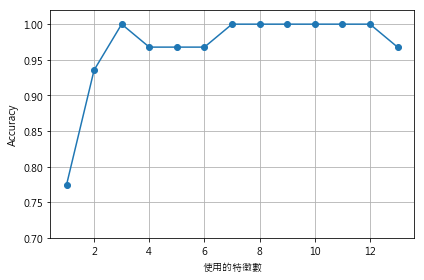

In [30]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('使用的特徵數',fontproperties="Microsoft JhengHei")
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

當k = 3,7:12 準確率為100%
那當然取最小的3阿,我們來看看是哪3個特徵

In [31]:
k3 = list(sbs.subsets_[-3])
print(df_wine.columns[1:][k3])


Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


使用KNN評估SBS所選出特徵的效果

In [32]:
knn.fit(X_train_std, y_train)
print('全特徵訓練準確度:', knn.score(X_train_std, y_train))
print('全特徵測試準確度:', knn.score(X_test_std, y_test))
knn.fit(X_train_std[:, k3], y_train)
print('SBS訓練準確度:', knn.score(X_train_std[:, k3], y_train))
print('SBS測試準確度:', knn.score(X_test_std[:, k3], y_test))

全特徵訓練準確度: 0.967741935483871
全特徵測試準確度: 0.9629629629629629
SBS訓練準確度: 0.9516129032258065
SBS測試準確度: 0.9259259259259259


發現光是使用3個特徵就足以描述出92%的資料，但是也有可能因為葡萄酒的資料數比較少，使它對隨機性比較敏感(切割資料集)．

#### Scikit-learn 邏輯式迴歸實作SBS

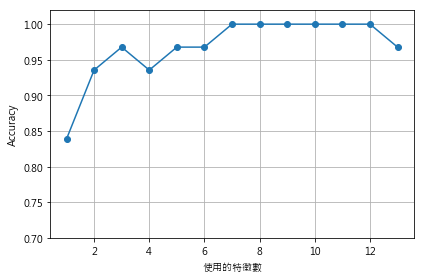

In [33]:
lr = LogisticRegression(penalty='l2', C=1.0,
                        solver='liblinear',
                        multi_class = 'ovr')
# selecting features
sbs = SBS(lr, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('使用的特徵數',fontproperties="Microsoft JhengHei")
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [34]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

當k = 7:12 準確率為100%
最小的為7,來看看是哪7個特徵

In [35]:
k7 = list(sbs.subsets_[-7])
print(df_wine.columns[1:][k7])

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Flavanoids',
       'Color intensity', 'Hue'],
      dtype='object')


跟剛剛用KNN相比少了'OD280/OD315 of diluted wines'這個特徵,還另外多了4個特徵.  
那如果只看3個特徵呢?其準確率也不差!

In [36]:
k3 = list(sbs.subsets_[-3])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Ash', 'Flavanoids'], dtype='object')


跟剛剛KNN相比唯一相同的只有'Alcohol'這個特徵了

In [37]:
lr.fit(X_train_std, y_train)
print('全特徵訓練準確度:', lr.score(X_train_std, y_train))
print('全特徵測試準確度:', lr.score(X_test_std, y_test))
lr.fit(X_train_std[:, k7], y_train)
print('SBS_K7訓練準確度:', lr.score(X_train_std[:, k7], y_train))
print('SBS_K7測試準確度:', lr.score(X_test_std[:, k7], y_test))

全特徵訓練準確度: 0.9919354838709677
全特徵測試準確度: 1.0
SBS_K7訓練準確度: 0.9838709677419355
SBS_K7測試準確度: 0.9814814814814815


In [38]:
lr.fit(X_train_std[:, k3], y_train)
print('SBS_K3訓練準確度:', lr.score(X_train_std[:, k3], y_train))
print('SBS_K3測試準確度:', lr.score(X_test_std[:, k3], y_test))

SBS_K3訓練準確度: 0.9354838709677419
SBS_K3測試準確度: 0.8888888888888888


發現邏輯式迴歸需要用到7個特徵才能解釋98%的資料，與使用全特徵相比下降不多。  
使用3個特徵在測試集上只能解釋88%的資料下降了10%,我覺得可能跟樣本數量少有關,KNN這種用距離計算相似度的演算法可能會比較合適.

### 重要性by隨機森林

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


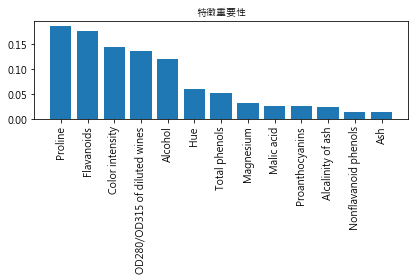

In [39]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
#argsort 依照大小排序後回船原本的index [::-1] 反向排列
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    #字串格式化
    print("%2d) %-*s %f" % (f + 1, #第一個空格前
                            30, feat_labels[indices[f]],  #第二個空格前 * 為輸入30的值 ,%-30s為向左靠其流最大長度30位元
                            importances[indices[f]]))

plt.title('特徵重要性',fontproperties="Microsoft JhengHei")
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

* 隨機森林重要性前五名特徵分別是Proline,Flavanoids,Color intensity,OD280/OD315 of diluted wines,Alcohol  
* KNN-SBS挑選的三個特徵分別是'Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'  
* Logistic-SBS挑選的7個特徵分別是'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Flavanoids','Color intensity', 'Hue'

隨機森林挑選出來的前五名在KNN-SBS(3)裡包含兩個特徵,在Logistic-SBS(7)裡則包含三個特徵.  
在隨機森林裡如果特徵間有高相關性,其中一個特徵可能排名很高,但是其與之高相關性的特徵排名可能就會很低(A與B高相關性,當A被選取後B能降的Gini就很有限,又或者考慮隨機性A與B的重要性排名可能很接近,但在剔除B之後A的排名有可能會上升許多)

In [40]:
print('RF全特徵訓練準確度:', forest.score(X_train, y_train))
print('RF全特徵測試準確度:', forest.score(X_test, y_test))
forest.fit(X_train[:,list(indices[0:5])], y_train)
print('RF全特徵訓練準確度:', forest.score(X_train[:,list(indices[0:5])], y_train))
print('RF全特徵測試準確度:', forest.score(X_test[:,list(indices[0:5])], y_test))

RF全特徵訓練準確度: 1.0
RF全特徵測試準確度: 1.0
RF全特徵訓練準確度: 1.0
RF全特徵測試準確度: 0.9814814814814815


發現使用重要性前五名跑一次測試集能解釋98%的資料,比使用全特徵時只下降了2%.

## 特徵提取(feature extraction)

特徵提取即**數據壓縮**,它將數據集轉換到新的、維度較低的**特徵子空間**
1. 主成分分析(PCA)
2. 線性判別分析(LCA)
3. 核主成分分析(KPCA)

### 主成分分析(Principal Compoment Analysis，PCA)
1. 標準化d維數據集
2. 建立共變異數矩陣(Covariance matrix)
3. 分解共變異矩陣為特徵向量(Eigenvector,投影軸)與特徵值(Eigenvalues,變異量)
4. 特徵向量以及特徵值依照特徵值以遞減方式排序
5. 選取k個最大特徵值相對應的特徵向量,k <=d
6. 用k個特徵向量建立投影矩陣W(Project matrix)
7. 用投影矩陣W轉換原始d維的數據集為新的k維特徵子集

#### 手動寫主成分分析

In [41]:
#計算共變異矩陣
cov_mat = np.cov(X_train_std.T)
#共變異矩陣的特徵解
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)



Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [42]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

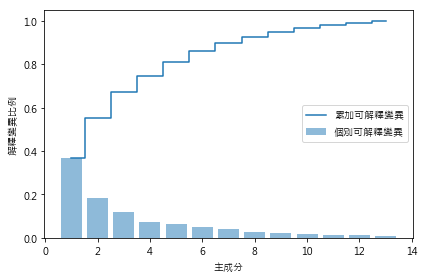

In [43]:
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='個別可解釋變異'#,fontproperties="Microsoft JhengHei"
       )
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='累加可解釋變異'#,fontproperties="Microsoft JhengHei"
        )
plt.ylabel('解釋變異比例',fontproperties="Microsoft JhengHei")
plt.xlabel('主成分')
plt.legend(loc='center right')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

In [44]:
eigen_pairs = [
                (np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))
                ]
# 根據cuple的第一個值由高到低排序list k可以任意設其他字母 
eigen_pairs.sort(key=lambda k: k[0], reverse=True)


In [45]:
eigen_pairs[0][1][:,np.newaxis]#.shape

array([[-0.13724218],
       [ 0.24724326],
       [-0.02545159],
       [ 0.20694508],
       [-0.15436582],
       [-0.39376952],
       [-0.41735106],
       [ 0.30572896],
       [-0.30668347],
       [ 0.07554066],
       [-0.32613263],
       [-0.36861022],
       [-0.29669651]])

In [46]:
np.transpose(eigen_pairs[0][1])

array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651])

根據特徵值最大的前兩個的特徵向量建立13x2的投影矩陣

In [47]:

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],#最大特徵值的特徵向量
               eigen_pairs[1][1][:, np.newaxis] #第二大
              ))
print('投影矩陣 W:\n', w)
print('投影矩陣 W shape: \n',w.shape)

投影矩陣 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]
投影矩陣 W shape: 
 (13, 2)


將原始經過標準化的資料和投影矩陣W內積轉換成主成份

In [48]:
X_train_pca = X_train_std.dot(w)

發現其實這組資料集用一條線性分類器就可以很好的分開三個類別了

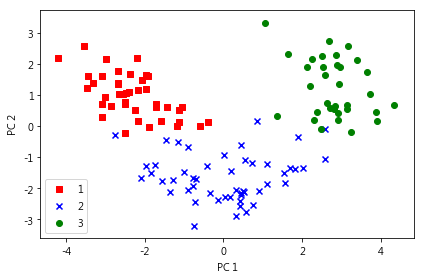

In [49]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

#### Scikit-Learn 主成分分析
將資料維度減少到只有兩個主成分,並藉由建立邏輯式迴歸觀察決策區域圖

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr_pca = LogisticRegression(solver='liblinear',
                            multi_class = 'ovr')
lr_pca = lr.fit(X_train_pca, y_train)

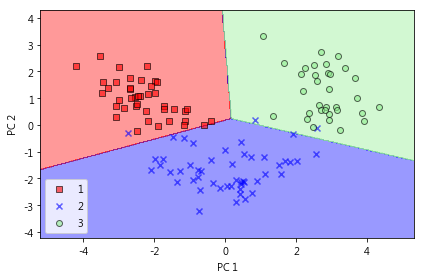

PCA訓練準確度: 0.9758064516129032


In [51]:
from myfun import plot_decision_regions
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
print('PCA訓練準確度:', lr_pca.score(X_train_pca, y_train))

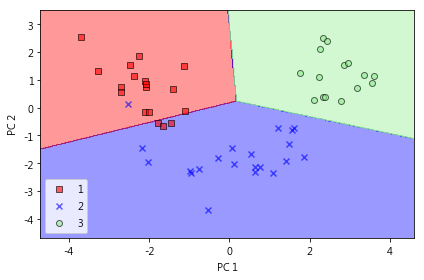

PCA測試準確度: 0.9259259259259259


In [52]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
print('PCA測試準確度:', lr_pca.score(X_test_pca, y_test))

##### 解釋變異數比率

In [53]:
#初始化主成份數
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

##### 主成分

In [54]:
pca.components_[0:2]

array([[-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
        -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
        -0.32613263, -0.36861022, -0.29669651],
       [ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
         0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
        -0.20716433, -0.24902536,  0.38022942]])

### 線性判別分析(Linear discriminant analysis，LCA)

* 嘗試找出最佳的特徵子空間來分離各個類別,並且避免交互重疊
    1. LDA希望資料投影後各個類別之間分散量越大越好,也就是群和群之間距離最大,越好判別區隔最好
    2. LDA希望資料投影後各個類別之內分散量(變異)越小越好


#### 步驟
1. 標準化d維數據集
2. 建立$S_W$組內(within-class)散佈量 -散佈矩陣(scatter matrix)   
   設數據集有i個類別,每個i類別都有j個數據,j會因為i的不同而不同:  
   $S_w = \sum_{i=1}S_i$  
   $S_i = \sum_{j=1} (x_j-m_i)(x_j - m_i)^T$
3. 縮放Scale: $ S_w = \sum_{i=1}\frac{S_i}{n_i}$ => 共變異數矩陣  
(LDA前提假設是類別的數量必須是均勻分布，但是現實資料很難達到，所以需要縮放Scale)
4. 建立$S_B$組間(between-class)散佈量 -散佈矩陣(scatter matrix)  
   $\bar m$ = 包含全類別的樣本平均值  
   $S_B = \sum_{i=1}\sum_{j=1}(m_i - \bar m)(m_i - \bar m)^T$  
   $S_B = \sum_{i=1}n_i(m_i - \bar m)(m_i - \bar m)^T$   
5. 從$S^{-1}_{w}S_B$計算特徵值和特徵向量  
($Fisher criterion : max J(W) = \frac{W^T S_B W}{W^T S_W W} => S^{-1}_{w}S_B W = \lambda W$ )  

6. 排序特徵值以及對應的特徵向量
7. 選擇對大的K個特徵值和相對應的特徵向量，建立dxk維的轉換矩陣(投影)W
8. 使用轉換矩陣將原數據集投影到新的特徵子空間中

計算各個類別各個特徵值的平均值向量

In [55]:
#控制陣列內容浮點數的列印精度(小數位數)到四位數
np.set_printoptions(precision=4)

#計算各個類別各個column的平均值,會是以向量表示
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], 
                             axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [56]:
mean_vecs

[array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
        -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075]),
 array([-0.8749, -0.2848, -0.3735,  0.3157, -0.3848, -0.0433,  0.0635,
        -0.0946,  0.0703, -0.8286,  0.3144,  0.3608, -0.7253]),
 array([ 0.1992,  0.866 ,  0.1682,  0.4148, -0.0451, -1.0286, -1.2876,
         0.8287, -0.7795,  0.9649, -1.209 , -1.3622, -0.4013])]

##### $S_w$組內(within-class)散佈矩陣(scatter matrix)   
   設數據集有i個類別,每個i類別都有j個數據,j會因為i的不同而不同:  
   $S_w = \sum_{i=1} S_i$  
   $S_i = \sum_{j=1} (x_j-m_i)(x_j - m_i)^T$

In [57]:
d = 13 # number of features

#先創建好都為0的 13x13矩陣
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # 先創建各個類別的散佈矩陣
    for row in X_train_std[y_train == label]:  #逐筆
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  #轉成向量
        class_scatter += (row - mv).dot((row - mv).T) 
    S_W += class_scatter                          # sum class scatter matrices

print('組內散佈矩陣: %sx%s' % (S_W.shape[0], S_W.shape[1]))

組內散佈矩陣: 13x13


##### 標準化 $ S_w $
$ S_w = \sum_{i=1}\frac{S_i}{n_i}$ => 共變異數矩陣 

In [58]:
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('標準化後組內散佈矩陣(共變異矩陣): %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

標準化後組內散佈矩陣(共變異矩陣): 13x13


##### 組間(between-class)散佈矩陣(scatter matrix)  
   $\bar m$ = 包含全類別的樣本平均值  
   $S_B = \sum_{i=1}\sum_{j=1}(m_i - \bar m)(m_i - \bar m)^T$  
   $S_B = \sum_{i=1}n_i(m_i - \bar m)(m_i - \bar m)^T$

In [59]:
mean_all = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):  #逐各類別平均
    n = X_train[y_train == i + 1, :].shape[0] #ni
    mean_vec = mean_vec.reshape(d, 1)  # 轉成向量
    mean_all = mean_all.reshape(d, 1)  # 轉成向量
    S_B += n * (mean_vec - mean_all).dot((mean_vec - mean_all).T)

print('組間散佈矩陣: %sx%s' % (S_B.shape[0], S_B.shape[1]))

組間散佈矩陣: 13x13


##### 計算特徵值和特徵向量   
$S^{-1}_{w} S_B w = \lambda w$

In [60]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

##### 排序特徵值

In [61]:
#(特徵值,特徵向量)
eigen_pairs = [
                (
                np.abs(eigen_vals[i]), eigen_vecs[:, i]
                                                        )
                for i in range(len(eigen_vals))
                                                          ]

# 排序特徵值
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)


print('由大到小排序特徵值:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

由大到小排序特徵值:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


LDA線性判別式的數目最多只有C-1個,C為類別個數,特徵值頭兩個為非0數值,其餘為很接近0的極小數值.(Numpy 浮點數計算誤差)

#### LDA-解釋變異數圖

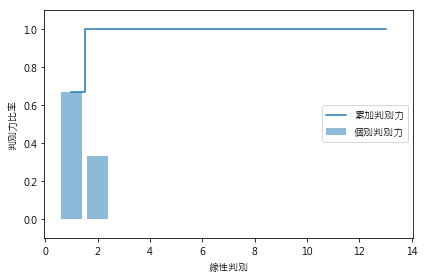

In [62]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='個別判別力')
plt.step(range(1, 14), cum_discr, where='mid',
         label='累加判別力')
plt.ylabel('判別力比率')
plt.xlabel('線性判別')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_07.png', dpi=300)
plt.show()

#### 投影W到新的特徵空間

與之前PCA所投影的特徵空間相比，類別間資料重疊的機會變低，類別彼此更能分開更適合線性分類器來運。

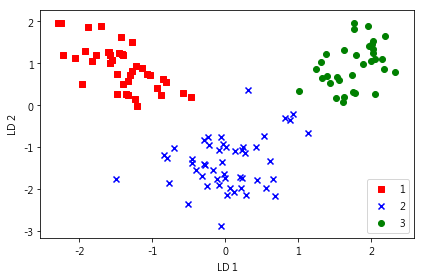

In [63]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/05_08.png', dpi=300)
plt.show()

#### Scikit-Leaarn LDA
將資料維度減少到只有兩個主成分,並藉由建立邏輯式迴歸觀察決策區域圖

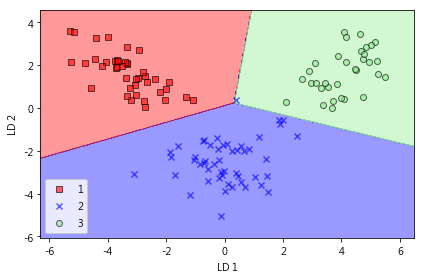

LDA訓練準確度: 0.9919354838709677


In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr_LDA = LogisticRegression(solver='liblinear',
                            multi_class = 'ovr')
lr_LDA = lr_LDA.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr_LDA)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_09.png', dpi=300)
plt.show()
print('LDA訓練準確度:', lr_LDA.score(X_train_lda, y_train))

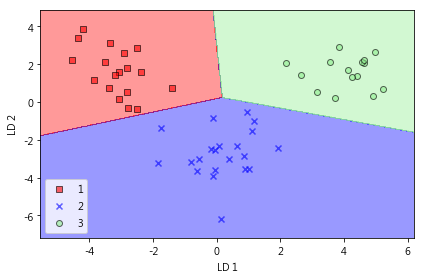

LDA測試準確度: 1.0


In [65]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('LDA測試準確度:', lr_LDA.score(X_test_lda, y_test))


### 核主成分分析(KPCA)

* 藉由核技巧$K = {\Phi(X)}^ \mathrm T \Phi(X)$ 運用核函數轉換數據來處理'非線性可分離'的數據降維問題  

#### 步驟(RBF為例)  

* 高斯核(Gaussian kernek or Radial Biasis Function kernel,RBF)  
$\gamma = \frac{1}{2\sigma} ,$  
$K(x^{(i)},x^{j}) = exp(-\gamma \|x^{(i)} - x^{(j)}\|^2)$  

    1. 定義核函數,ex:RBF、多項式核(polynomial kernal)等
    2. 計算核矩陣$K_{n\times n}$ , n為樣本數  
    $$
     K_{n\times n} = 
     \left[
     \begin{matrix}
       K(x^{(1)},x^{1}) & K(x^{(1)},x^{2}) & \cdots & K(x^{(1)},x^{n}) \\
       K(x^{(2)},x^{1}) & K(x^{(2)},x^{2}) & \cdots & K(x^{(2)},x^{n}) \\
        \vdots & \vdots & \ddots & \vdots \\
       K(x^{(n)},x^{1}) & K(x^{(n)},x^{2}) & \cdots & K(x^{(n)},x^{n}) \\
      \end{matrix}
      \right] 
    $$
    3. 核矩陣$K$中心化:  
    $\quad 1_{N \times 1} = \left[1,1,..., 1 \right]^\mathrm T$  
    $\quad 1_N  = \frac {1}{N}1_{N \times 1} {1_{N \times 1}}^\mathrm T ，$即全部為$\frac{1}{N}$的矩陣  
       矩陣X中心化可表示為:  
        $\quad \Phi(X)' = \Phi(X) - \Phi(X)1_N $  
       故核矩陣中心化:  
        $\quad K' = {\Phi(X)^{'}}^ \mathrm T \Phi(X)^{'} \\
        = \left[\Phi(X) - \Phi(X)1_N \right]^\mathrm T \left[\Phi(X) - \Phi(X)1_N \right]$  
        $\quad \Phi(X)^\mathrm T \Phi(X) - \Phi(X)^\mathrm T \Phi(X) 1_N - {1_N}^\mathrm T \Phi(X)^\mathrm T \Phi(X) + {1_N}^\mathrm T \Phi(X)^\mathrm T \Phi(X) 1_N$  
        又${1_N}^\mathrm T = 1_N ，$  
        $\quad K' = K - K1_N - 1_NK + 1_NK1_N$
    4. 分解矩陣$K'$為特徵向量與特徵值(解$\frac{1}{n}Ka=\lambda a$)  
    5. 排序特徵值取前幾個相對應的特徵向量

In [66]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset   

    """
    # 計算歐式距離的平方
    # pdist 傳回向量
    k_dists = pdist(X, 'sqeuclidean')

    # 轉回矩陣(對稱矩陣)
    k_dists_matr = squareform(k_dists)

    # 計算核矩陣
    K = exp(-gamma * k_dists_matr)

    # 矩陣中心化
    N = K.shape[0]
    ##製作全都是1/N的(N,N)矩陣
    one_n = np.ones((N, N)) / N
    # 步驟3. 推導的公式
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    #特徵分解
    eigvals, eigvecs = eigh(K)
    #依照大到小排序
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 收集前k個特徵向量
    # np.column_stack類似r的cbind
    X_pc = np.column_stack((eigvecs[:, i]
                            for i in range(n_components)))

    return X_pc

#### Data set 試作

##### EX.1 半月的Data set

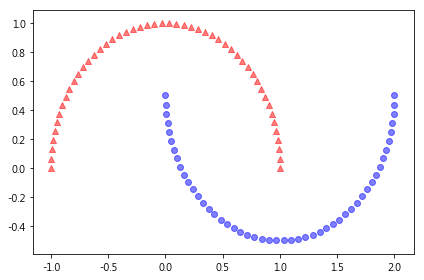

In [161]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_12.png', dpi=300)
plt.show()

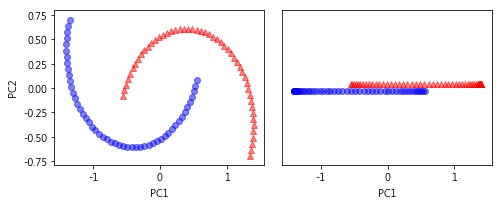

In [162]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

# 經pca 轉換後第一主成分與第二主成分繪製圖
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)
# 只看第一主成分 ,y軸(第二主成分)被固定住用來觀察第一主成分類別重疊效果
ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.05,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.05,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

左圖是經過PCA轉軸映射之後的數據圖，右圖是只提取第一主成分的圖．　　
可以發現PCA沒辦法很好的將我們的數據分離，中間部分還是有很大一部分重疊．

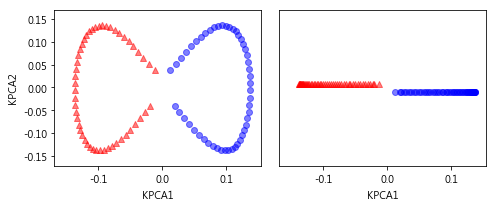

In [163]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.05, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.05,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('KPCA1')
ax[0].set_ylabel('KPCA2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('KPCA1')

plt.tight_layout()
plt.show()

再套用過RBF核的KPCA後可以發現數據可以經過線性分類器處理了．

##### EX.2 同心圓Data set

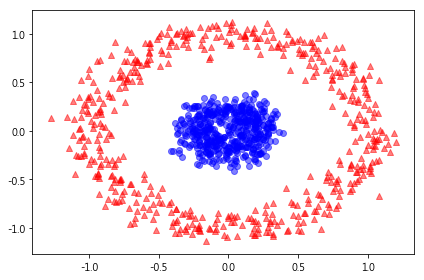

In [164]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

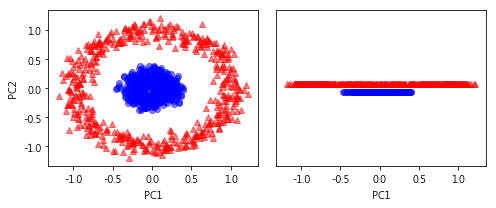

In [165]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.05,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.05,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

一樣我們可以發現PCA沒辦法很好的處理這樣的數據集．

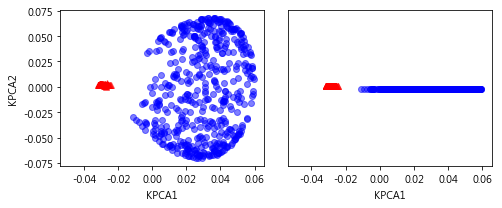

In [166]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('KPCA1')
ax[0].set_ylabel('KPCA2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('KPCA1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

套用KPCA後數據可以被線性分類器很好的分類

##### EX.3 現實情況Data set!?

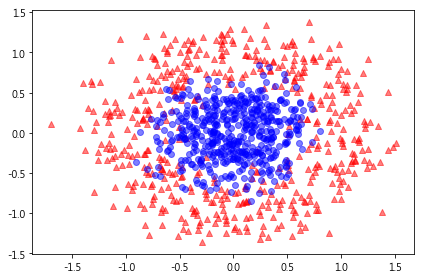

In [167]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.25, factor=0.3)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
plt.show()

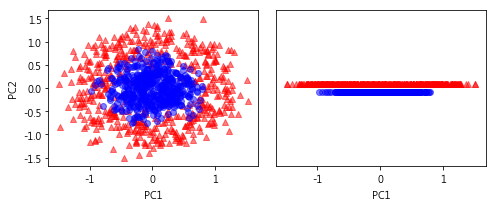

In [168]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.05,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.05,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

PCA一樣也沒辦法很好的分離我們的數據，而且這次數據有更多的點重疊再一起了．

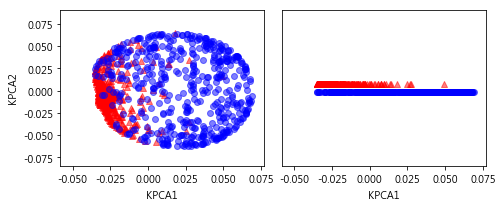

In [169]:
X_kpca = rbf_kernel_pca(X, gamma=5, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.05,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.05,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('KPCA1')
ax[0].set_ylabel('KPCA2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('KPCA1')

plt.tight_layout()
plt.show()

可以看到我們的KPCA也沒有表現得很好，可能需要去Tune $\gamma$ 來找尋最優解。  

#### Scikit-Leaarn KPCA

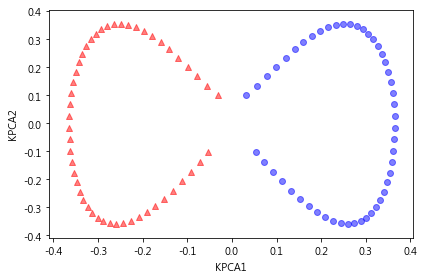

In [170]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('KPCA1')
plt.ylabel('KPCA2')
plt.tight_layout()
plt.show()